In [86]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Northeastern/Projects/IE6600 Final Project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Northeastern/Projects/IE6600 Final Project


In [87]:
# install additional clustering modules
!pip install validclust
!pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [88]:
import os
import json
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster   import hierarchy as shc # dendrogram
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import calinski_harabasz_score as ch_score, silhouette_score as ss
from sklearn.metrics.pairwise import euclidean_distances
from validclust import ValidClust
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [89]:
data = pd.read_csv('Data/Cleaned_Data.csv')
data = data.iloc[:,1:]
data

,level_0,level_1,NY.GDP.MKTP.KD.ZG,GC.XPN.INTP.CN,GC.XPN.TOTL.GD.ZS,GC.DOD.TOTL.GD.ZS,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD,NY.GDP.PCAP.PP.CD,NY.GNS.ICTR.ZS,...,NY.GDP.TOTL.RT.ZS.1,BX.KLT.DINV.CD.WD.1,SL.TLF.CACT.MA.ZS,SP.POP.DPND,SH.IMM.IDPT,SH.IMM.MEAS,SP.POP.1564.TO.ZS.1,SP.POP.1564.TO.ZS.2,SL.TLF.TOTL.IN,SP.POP.1564.TO
0,AUS,1990,3.573507,7.364000e+09,21.822977,12.231535,3.113267e+11,18243.471418,17367.110580,24.305460,...,3.483265,8.457777e+09,75.543999,49.584532,95.0,86.0,66.851833,66.851833,8475893.0,11408332.0
1,AUS,1991,-0.395087,6.192000e+09,23.171087,11.921499,3.259030e+11,18855.761996,17822.475281,20.682046,...,2.549693,2.612067e+09,74.596001,49.565534,93.0,86.0,66.860327,66.860327,8524976.0,11556139.0
2,AUS,1992,0.413780,5.748000e+09,24.439892,14.147185,3.254803e+11,18604.188270,18214.597871,18.178875,...,2.418013,4.941907e+09,74.085999,49.742895,91.0,86.0,66.781131,66.781131,8601726.0,11683359.0
3,AUS,1993,4.033567,5.413000e+09,24.969497,17.874332,3.121262e+11,17667.187100,19159.521590,20.168552,...,2.087932,5.312435e+09,73.511002,50.009149,90.0,86.0,66.662599,66.662599,8634061.0,11777281.0
4,AUS,1994,3.980474,6.630000e+09,25.092045,20.188463,3.228073e+11,18079.380179,20094.054111,21.720309,...,1.992354,4.458484e+09,73.569000,50.190276,88.0,86.0,66.582205,66.582205,8799677.0,11888253.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,IND,2016,8.256306,4.791960e+12,15.271950,47.633756,2.294798e+12,1732.554242,5839.864817,30.830576,...,1.732259,4.445857e+10,75.139000,50.888137,88.0,88.0,66.274262,66.274262,469541836.0,877814039.0
430,IND,2017,6.795383,5.292460e+12,15.614110,47.583609,2.651473e+12,1980.667020,6182.922109,31.706754,...,1.964858,3.996609e+10,74.348999,50.289637,89.0,90.0,66.538187,66.538187,471675710.0,890731260.0
431,IND,2018,6.453851,5.741910e+12,15.663132,46.522499,2.702930e+12,1998.259076,6669.622784,31.410492,...,2.247346,4.211745e+10,73.551003,49.775167,90.0,93.0,66.766742,66.766742,473422438.0,903115190.0
432,IND,2019,3.737919,NaN,NaN,NaN,2.831552e+12,2072.244897,6971.687276,29.697750,...,1.991762,5.061065e+10,73.245003,49.245242,91.0,95.0,67.003811,67.003811,482700285.0,915551973.0


## Scaling

In [90]:
# scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(data.iloc[:,2:])

data_scaled = pd.DataFrame(scaled_x, columns=data.columns[2:])
# data_scaled = pd.concat([data.iloc[:,:2], data_scaled], axis=1)
data_scaled2 = data_scaled.fillna(data_scaled.rolling(6,min_periods=1).mean())
data_scaled2

,NY.GDP.MKTP.KD.ZG,GC.XPN.INTP.CN,GC.XPN.TOTL.GD.ZS,GC.DOD.TOTL.GD.ZS,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD,NY.GDP.PCAP.PP.CD,NY.GNS.ICTR.ZS,NY.GDP.DEFL.KD.ZG,GC.XPN.INTP.ZS,...,NY.GDP.TOTL.RT.ZS.1,BX.KLT.DINV.CD.WD.1,SL.TLF.CACT.MA.ZS,SP.POP.DPND,SH.IMM.IDPT,SH.IMM.MEAS,SP.POP.1564.TO.ZS.1,SP.POP.1564.TO.ZS.2,SL.TLF.TOTL.IN,SP.POP.1564.TO
0,0.601055,0.000349,0.271021,0.037345,0.014404,0.264420,0.159702,0.392794,0.001545,0.163892,...,0.245758,0.126472,0.610769,0.327659,0.906977,0.767857,0.570787,0.570787,0.015980,0.010797
1,0.456416,0.000294,0.304188,0.035993,0.015086,0.273443,0.164200,0.314203,0.001057,0.126457,...,0.179888,0.116320,0.579182,0.327384,0.860465,0.767857,0.571094,0.571094,0.016082,0.010956
2,0.485896,0.000273,0.335403,0.045705,0.015066,0.269736,0.168074,0.259910,0.000811,0.109194,...,0.170597,0.120366,0.562190,0.329956,0.813953,0.767857,0.568236,0.568236,0.016241,0.011094
3,0.617822,0.000257,0.348432,0.061969,0.014441,0.255927,0.177408,0.303066,0.000713,0.095892,...,0.147307,0.121010,0.543031,0.333817,0.790698,0.767857,0.563958,0.563958,0.016308,0.011195
4,0.615887,0.000314,0.351447,0.072068,0.014941,0.262001,0.186640,0.336723,0.000734,0.111267,...,0.140563,0.119527,0.544964,0.336444,0.744186,0.767857,0.561057,0.561057,0.016652,0.011315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,0.771723,0.227222,0.109851,0.191833,0.107223,0.021095,0.045831,0.534322,0.001088,0.400574,...,0.122212,0.188996,0.597275,0.346564,0.744186,0.803571,0.549945,0.549945,0.972696,0.945566
430,0.718479,0.250954,0.118269,0.191614,0.123915,0.024751,0.049220,0.553327,0.001205,0.389714,...,0.138623,0.181193,0.570953,0.337884,0.767442,0.839286,0.559469,0.559469,0.977124,0.959503
431,0.706031,0.272266,0.119475,0.186984,0.126323,0.025011,0.054028,0.546901,0.001191,0.381130,...,0.158555,0.184930,0.544364,0.330424,0.790698,0.892857,0.567717,0.567717,0.980748,0.972864
432,0.607047,0.228180,0.110433,0.194833,0.132342,0.026101,0.057012,0.509752,0.000953,0.399144,...,0.140522,0.199680,0.534169,0.322739,0.813953,0.928571,0.576271,0.576271,1.000000,0.986282


## Correlation

In [91]:
# plot correlation
fig = px.imshow(data_scaled2.corr(), 
                color_continuous_scale='RdBu_r', 
                origin='upper', 
                aspect='equal')
fig.update_layout(width=1000, height=1000, margin=dict(l=10, r=10, b=10, t=10))
fig.show()

## KMeans Clustering

In [92]:
[print(a, b) for (a,b) in zip(data_scaled2.columns, data_scaled2.isna().sum().values)];

NY.GDP.MKTP.KD.ZG 0
GC.XPN.INTP.CN 7
GC.XPN.TOTL.GD.ZS 1
GC.DOD.TOTL.GD.ZS 19
NY.GDP.MKTP.CD 0
NY.GDP.PCAP.CD 0
NY.GDP.PCAP.PP.CD 0
NY.GNS.ICTR.ZS 0
NY.GDP.DEFL.KD.ZG 0
GC.XPN.INTP.ZS 8
SL.UEM.TOTL.ZS 1
FR.INR.RINR 16
FP.CPI.TOTL.ZG 0
BX.KLT.DINV.CD.WD 0
FR.INR.LNDP 87
FR.INR.LEND 14
FM.LBL.BMNY.GD.ZS 0
CM.MKT.LCAP.GD.ZS 53
FS.AST.PRVT.GD.ZS 12
CM.MKT.TRAD.GD.ZS 38
NE.EXP.GNFS.ZS 0
NE.IMP.GNFS.ZS 0
SL.TLF.ACTI.ZS 0
EN.ATM.CO2E.PC 0
EG.ELC.RNWX.ZS 0
AG.PRD.FOOD.XD 0
AG.LND.FRST.ZS 0
FS.AST.PRVT.GD.ZS.1 12
TG.VAL.TOTL.GD.ZS 0
GC.DOD.TOTL.GD.ZS.1 19
GC.XPN.TOTL.GD.ZS.1 1
MS.MIL.XPND.GD.ZS 0
GC.AST.TOTL.GD.ZS 83
GC.LBL.TOTL.GD.ZS 43
GC.NFN.TOTL.GD.ZS 3
GC.NLD.TOTL.GD.ZS 1
GC.REV.XGRT.GD.ZS 0
GC.TAX.TOTL.GD.ZS 0
TG.VAL.TOTL.GD.ZS.1 0
NY.GDP.TOTL.RT.ZS 0
DT.DOD.DPPG.CD 197
DT.DOD.DECT.CD 197
SP.RUR.TOTL.ZS 0
SL.AGR.EMPL.MA.ZS 1
SP.POP.TOTL 0
SP.POP.GROW 0
SP.URB.TOTL.IN.ZS 0
EN.URB.MCTY.TL.ZS 26
EG.ELC.ACCS.ZS 5
SI.POV.DDAY 108
SP.POP.0014.TO.ZS 0
SP.POP.1564.TO.ZS 0
EN.POP.EL5M.ZS.1 200
EN.

In [93]:
data_scaled2.drop(columns=['GC.AST.TOTL.GD.ZS',
                           'EN.POP.EL5M.ZS.1',
                           'DT.DOD.DPPG.CD',
                           'DT.DOD.DECT.CD',
                           'PX.REX.REER'
                           ], axis=1)

,NY.GDP.MKTP.KD.ZG,GC.XPN.INTP.CN,GC.XPN.TOTL.GD.ZS,GC.DOD.TOTL.GD.ZS,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD,NY.GDP.PCAP.PP.CD,NY.GNS.ICTR.ZS,NY.GDP.DEFL.KD.ZG,GC.XPN.INTP.ZS,...,NY.GDP.TOTL.RT.ZS.1,BX.KLT.DINV.CD.WD.1,SL.TLF.CACT.MA.ZS,SP.POP.DPND,SH.IMM.IDPT,SH.IMM.MEAS,SP.POP.1564.TO.ZS.1,SP.POP.1564.TO.ZS.2,SL.TLF.TOTL.IN,SP.POP.1564.TO
0,0.601055,0.000349,0.271021,0.037345,0.014404,0.264420,0.159702,0.392794,0.001545,0.163892,...,0.245758,0.126472,0.610769,0.327659,0.906977,0.767857,0.570787,0.570787,0.015980,0.010797
1,0.456416,0.000294,0.304188,0.035993,0.015086,0.273443,0.164200,0.314203,0.001057,0.126457,...,0.179888,0.116320,0.579182,0.327384,0.860465,0.767857,0.571094,0.571094,0.016082,0.010956
2,0.485896,0.000273,0.335403,0.045705,0.015066,0.269736,0.168074,0.259910,0.000811,0.109194,...,0.170597,0.120366,0.562190,0.329956,0.813953,0.767857,0.568236,0.568236,0.016241,0.011094
3,0.617822,0.000257,0.348432,0.061969,0.014441,0.255927,0.177408,0.303066,0.000713,0.095892,...,0.147307,0.121010,0.543031,0.333817,0.790698,0.767857,0.563958,0.563958,0.016308,0.011195
4,0.615887,0.000314,0.351447,0.072068,0.014941,0.262001,0.186640,0.336723,0.000734,0.111267,...,0.140563,0.119527,0.544964,0.336444,0.744186,0.767857,0.561057,0.561057,0.016652,0.011315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,0.771723,0.227222,0.109851,0.191833,0.107223,0.021095,0.045831,0.534322,0.001088,0.400574,...,0.122212,0.188996,0.597275,0.346564,0.744186,0.803571,0.549945,0.549945,0.972696,0.945566
430,0.718479,0.250954,0.118269,0.191614,0.123915,0.024751,0.049220,0.553327,0.001205,0.389714,...,0.138623,0.181193,0.570953,0.337884,0.767442,0.839286,0.559469,0.559469,0.977124,0.959503
431,0.706031,0.272266,0.119475,0.186984,0.126323,0.025011,0.054028,0.546901,0.001191,0.381130,...,0.158555,0.184930,0.544364,0.330424,0.790698,0.892857,0.567717,0.567717,0.980748,0.972864
432,0.607047,0.228180,0.110433,0.194833,0.132342,0.026101,0.057012,0.509752,0.000953,0.399144,...,0.140522,0.199680,0.534169,0.322739,0.813953,0.928571,0.576271,0.576271,1.000000,0.986282


In [94]:
data_scaled2.fillna(0, inplace=True)

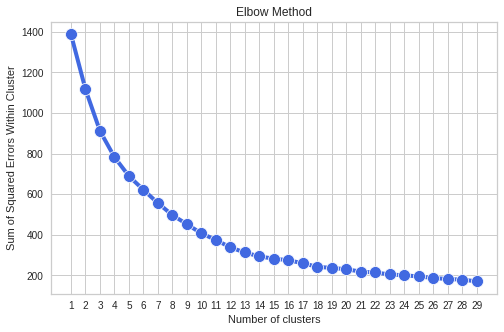

In [95]:
# elbow method
sse_wc = []  

num_clusters = 30
for i in range(1,num_clusters):
    model = KMeans(n_clusters = i)
    model.fit(data_scaled2)
    # store the inertia value
    sse_wc.append(model.inertia_)

plt.figure(figsize=(8,5))
sns.lineplot(x=range(1,num_clusters), y=sse_wc, 
             linewidth=4, markersize=12, marker='o', color='royalblue');
plt.xticks(range(1,num_clusters))
plt.title('Elbow Method')
plt.xlabel("Number of clusters")
plt.ylabel("Sum of Squared Errors Within Cluster")
plt.show()

In [96]:
# get the internal validation metrics
vclust = ValidClust(
    k=list(range(2, num_clusters)), 
    methods=['hierarchical', 'kmeans']
)

cvi_vals = vclust.fit_predict(data_scaled2)
# melt dataframe
i_vals = cvi_vals.unstack(level=-1).stack(level=0)
# save hierarchical clustering metrics
hier = i_vals.loc['hierarchical']
# save kmeans clustering metrics
kmeans = i_vals.loc['kmeans']

<ipython-input-97-e8e208f14f84>:4: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



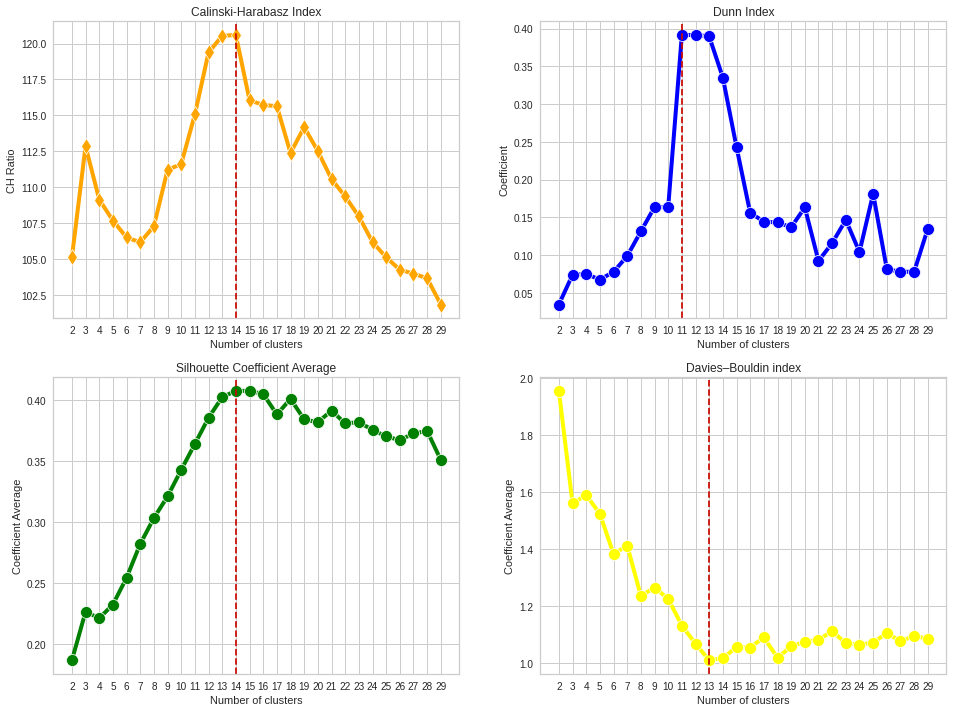

In [97]:
# plot internal validation metrics
fig, axs = plt.subplots(2, 2, figsize = (16, 12), 
                        gridspec_kw={'hspace': 0.2, 'wspace': 0.2})
plt.tight_layout()

# plot CH score metrics
sns.lineplot(x=kmeans.index, y=kmeans['calinski'], 
             linewidth=4, markersize=12, marker='d', color='orange', ax=axs[0][0])
axs[0][0].axvline(x=kmeans.index[np.argmax(kmeans['calinski'])], color='r', linestyle='--')
axs[0][0].set_xlabel("Number of clusters")
axs[0][0].set_ylabel("CH Ratio")
axs[0][0].set_xticks(range(2,num_clusters))
axs[0][0].set_title("Calinski-Harabasz Index")

# plot Dunn Index
sns.lineplot(x=kmeans.index, y=kmeans['dunn'], 
             linewidth=4, markersize=12, marker='o', color='blue', ax=axs[0][1])
axs[0][1].axvline(x=kmeans.index[np.argmax(kmeans['dunn'])], color='r', linestyle='--')
axs[0][1].set_xlabel("Number of clusters")
axs[0][1].set_ylabel("Coefficient")
axs[0][1].set_xticks(range(2,num_clusters))
axs[0][1].set_title("Dunn Index")

# plot silhouette score average
sns.lineplot(x=kmeans.index, y=kmeans['silhouette'], 
             linewidth=4, markersize=12, marker='o', color='green', ax=axs[1][0])
axs[1][0].axvline(x=kmeans.index[np.argmax(kmeans['silhouette'])], color='r', linestyle='--')
axs[1][0].set_xlabel("Number of clusters")
axs[1][0].set_ylabel("Coefficient Average")
axs[1][0].set_xticks(range(2,num_clusters))
axs[1][0].set_title("Silhouette Coefficient Average")

# plot DB Index score average
sns.lineplot(x=kmeans.index, y=kmeans['davies'], 
             linewidth=4, markersize=12, marker='o', color='yellow', ax=axs[1][1])
axs[1][1].axvline(x=kmeans.index[np.argmin(kmeans['davies'])], color='r', linestyle='--')
axs[1][1].set_xlabel("Number of clusters")
axs[1][1].set_ylabel("Coefficient Average")
axs[1][1].set_xticks(range(2,num_clusters))
axs[1][1].set_title("Davies–Bouldin index")

plt.show()

## Model

In [98]:
# KMeans model
model = KMeans(n_clusters = 14, 
               init = "k-means++", 
               max_iter = 100, 
               n_init = 15, 
               random_state = 365)
# predictions
y_pred = model.fit_predict(data_scaled2)

In [99]:
len(y_pred)

434

In [100]:
data_3 = pd.concat([data, pd.Series(y_pred, name='prediction')], axis=1)
data_3

,level_0,level_1,NY.GDP.MKTP.KD.ZG,GC.XPN.INTP.CN,GC.XPN.TOTL.GD.ZS,GC.DOD.TOTL.GD.ZS,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD,NY.GDP.PCAP.PP.CD,NY.GNS.ICTR.ZS,...,BX.KLT.DINV.CD.WD.1,SL.TLF.CACT.MA.ZS,SP.POP.DPND,SH.IMM.IDPT,SH.IMM.MEAS,SP.POP.1564.TO.ZS.1,SP.POP.1564.TO.ZS.2,SL.TLF.TOTL.IN,SP.POP.1564.TO,prediction
0,AUS,1990,3.573507,7.364000e+09,21.822977,12.231535,3.113267e+11,18243.471418,17367.110580,24.305460,...,8.457777e+09,75.543999,49.584532,95.0,86.0,66.851833,66.851833,8475893.0,11408332.0,10
1,AUS,1991,-0.395087,6.192000e+09,23.171087,11.921499,3.259030e+11,18855.761996,17822.475281,20.682046,...,2.612067e+09,74.596001,49.565534,93.0,86.0,66.860327,66.860327,8524976.0,11556139.0,10
2,AUS,1992,0.413780,5.748000e+09,24.439892,14.147185,3.254803e+11,18604.188270,18214.597871,18.178875,...,4.941907e+09,74.085999,49.742895,91.0,86.0,66.781131,66.781131,8601726.0,11683359.0,10
3,AUS,1993,4.033567,5.413000e+09,24.969497,17.874332,3.121262e+11,17667.187100,19159.521590,20.168552,...,5.312435e+09,73.511002,50.009149,90.0,86.0,66.662599,66.662599,8634061.0,11777281.0,10
4,AUS,1994,3.980474,6.630000e+09,25.092045,20.188463,3.228073e+11,18079.380179,20094.054111,21.720309,...,4.458484e+09,73.569000,50.190276,88.0,86.0,66.582205,66.582205,8799677.0,11888253.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,IND,2016,8.256306,4.791960e+12,15.271950,47.633756,2.294798e+12,1732.554242,5839.864817,30.830576,...,4.445857e+10,75.139000,50.888137,88.0,88.0,66.274262,66.274262,469541836.0,877814039.0,7
430,IND,2017,6.795383,5.292460e+12,15.614110,47.583609,2.651473e+12,1980.667020,6182.922109,31.706754,...,3.996609e+10,74.348999,50.289637,89.0,90.0,66.538187,66.538187,471675710.0,890731260.0,7
431,IND,2018,6.453851,5.741910e+12,15.663132,46.522499,2.702930e+12,1998.259076,6669.622784,31.410492,...,4.211745e+10,73.551003,49.775167,90.0,93.0,66.766742,66.766742,473422438.0,903115190.0,7
432,IND,2019,3.737919,NaN,NaN,NaN,2.831552e+12,2072.244897,6971.687276,29.697750,...,5.061065e+10,73.245003,49.245242,91.0,95.0,67.003811,67.003811,482700285.0,915551973.0,7


In [101]:
fig = px.choropleth(data_3, locations="level_0",
                    color="prediction", 
                    hover_name="level_0",
                    color_continuous_scale=px.colors.sequential.Magma,
                    )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [102]:
for i in range(14):
    print(i, data_3['level_0'][data_3['prediction'] == i].unique())

0 ['GBR' 'HUN']
1 ['JAM' 'PER']
2 ['SGP']
3 ['KOR']
4 ['ROU']
5 ['JOR']
6 ['USA']
7 ['IND']
8 ['THA']
9 ['SWE']
10 ['AUS']
11 ['PER']
12 ['HUN']
13 ['PHL']
